<a href="https://colab.research.google.com/github/w15d0177/AIFFEL_quest_cr/blob/main/Exploration/Quest03/DeepLabV3_MediaPipeSelfieSegmentation_shared_by_Jindeok.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step


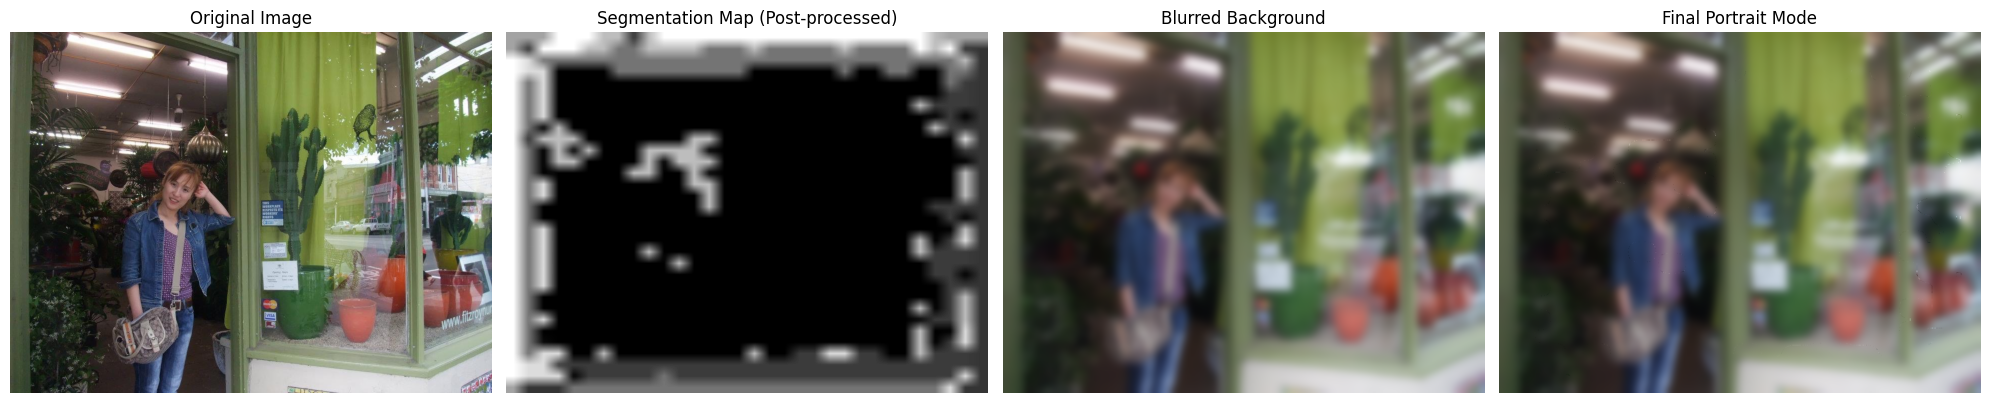

JihyeKIM.JPG 처리가 완료되었습니다. 결과 저장: /content/drive/MyDrive/AIFFEL_2024/shallow_focus/output_deeplabv3/portrait_JihyeKIM.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


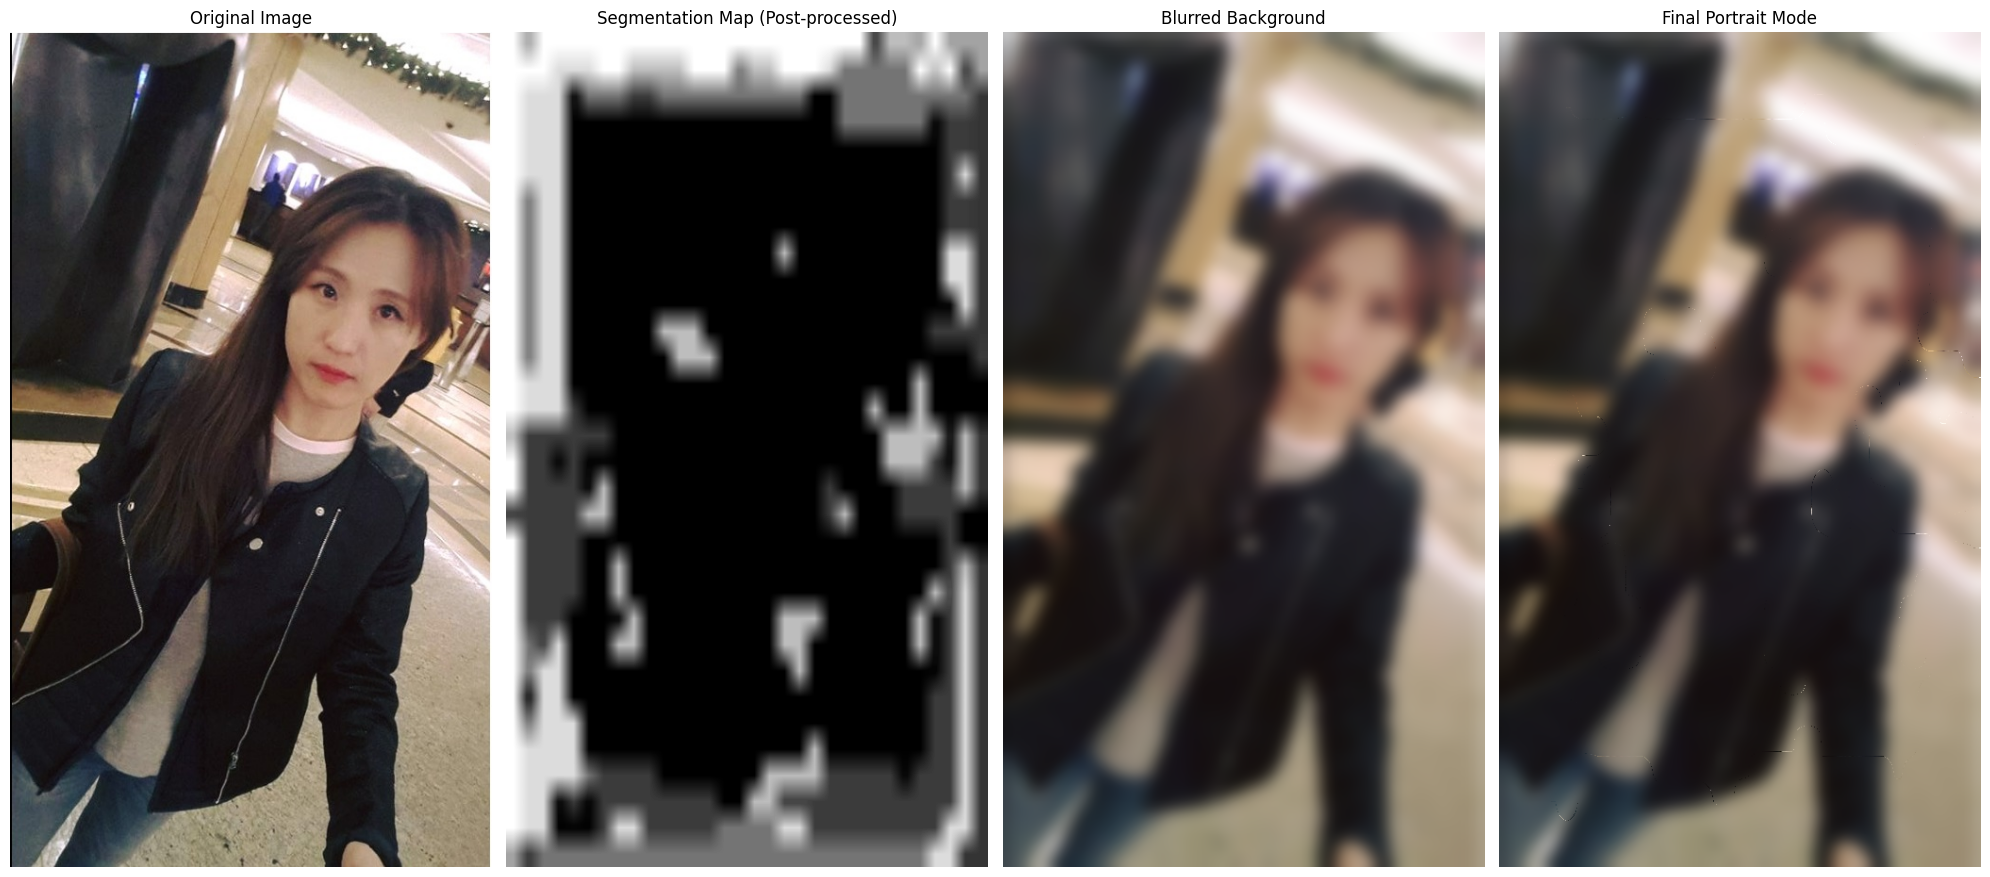

Jihye_KIM.jpg 처리가 완료되었습니다. 결과 저장: /content/drive/MyDrive/AIFFEL_2024/shallow_focus/output_deeplabv3/portrait_Jihye_KIM.jpg
모든 이미지 처리가 완료되었습니다.


In [23]:
# DeepLabV3+ 모델 로드 (ResNet-101 백본 사용, 입력 크기 변경)
model = tf.keras.applications.ResNet101(weights='imagenet', include_top=False, input_shape=(1024, 1024, 3))

# 이미지 경로 설정
image_folder = '/content/drive/MyDrive/AIFFEL_2024/shallow_focus_data/'
output_folder = '/content/drive/MyDrive/AIFFEL_2024/shallow_focus/output_deeplabv3'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 이미지 파일 처리
for image_name in os.listdir(image_folder):
    img_path = os.path.join(image_folder, image_name)

    image = cv2.imread(img_path)
    if image is None:
        print(f"이미지 {image_name}를 읽을 수 없습니다. 건너뜁니다.")
        continue

    original_size = (image.shape[1], image.shape[0])
    input_image = cv2.resize(image, (1024, 1024))  # 더 큰 해상도로 변경
    input_image = np.expand_dims(input_image, axis=0)
    input_image = tf.cast(input_image, tf.float32) / 127.5 - 1

    # 모델 예측
    predictions = model.predict(input_image)
    segmentation_map = np.argmax(predictions, axis=-1)[0]

    # 원본 크기로 세그멘테이션 맵 리사이즈
    segmentation_map = cv2.resize(segmentation_map.astype(np.uint8), original_size)

    # 모폴로지 연산 적용 (팽창 후 침식으로 인물 영역 확실히)
    kernel = np.ones((5, 5), np.uint8)
    segmentation_map = cv2.morphologyEx(segmentation_map, cv2.MORPH_CLOSE, kernel)

    # 배경 흐림 처리
    blurred_bg = cv2.GaussianBlur(image, (55, 55), 0)

    # 마스크를 사용하여 인물만 남기기
    # 세그멘테이션 맵에서 인물로 인식된 부분을 남김 (segmentation_map == 사람의 클래스 번호)
    condition = segmentation_map == 15  # 클래스 15가 인물을 나타낸다고 가정

    # 3채널 마스크 생성 (True는 인물, False는 배경)
    mask = np.stack([condition] * 3, axis=-1)

    # 최종 결과 이미지 생성 (인물은 원본, 배경은 흐림 처리된 이미지)
    output_image = np.where(mask, image, blurred_bg)

    # 시각적 비교
    fig, axes = plt.subplots(1, 4, figsize=(20, 10))

    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(segmentation_map, cmap='gray')
    axes[1].set_title("Segmentation Map (Post-processed)")
    axes[1].axis('off')

    axes[2].imshow(cv2.cvtColor(blurred_bg, cv2.COLOR_BGR2RGB))
    axes[2].set_title("Blurred Background")
    axes[2].axis('off')

    axes[3].imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    axes[3].set_title("Final Portrait Mode")
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

    output_path = os.path.join(output_folder, f"portrait_{image_name}")
    cv2.imwrite(output_path, output_image)
    print(f"{image_name} 처리가 완료되었습니다. 결과 저장: {output_path}")

print("모든 이미지 처리가 완료되었습니다.")

In [24]:
!pip install mediapipe

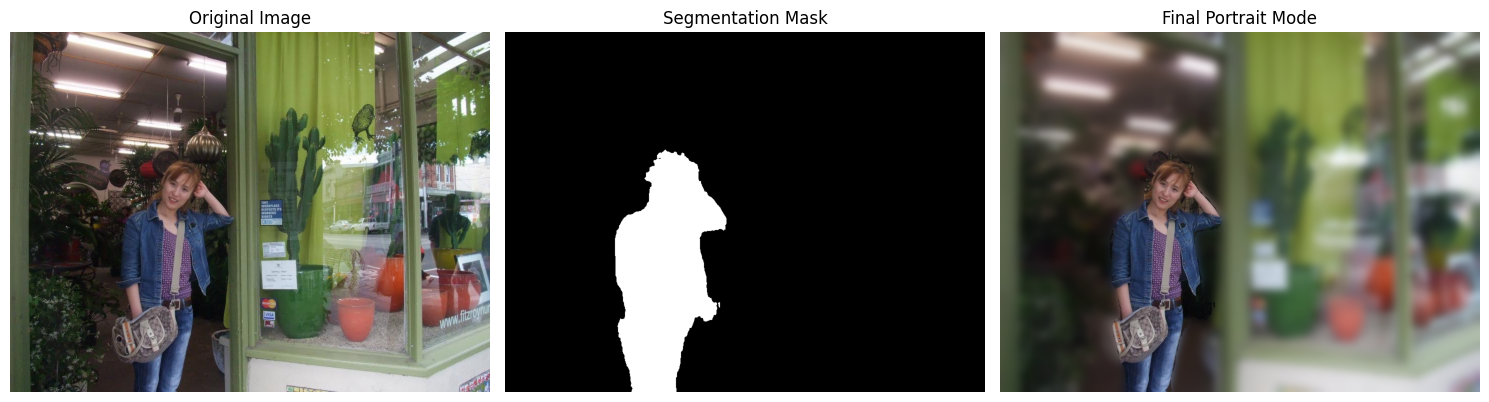

JihyeKIM.JPG 처리가 완료되었습니다. 결과 저장: /content/drive/MyDrive/AIFFEL_2024/shallow_focus/output_mediapipe/portrait_JihyeKIM.JPG


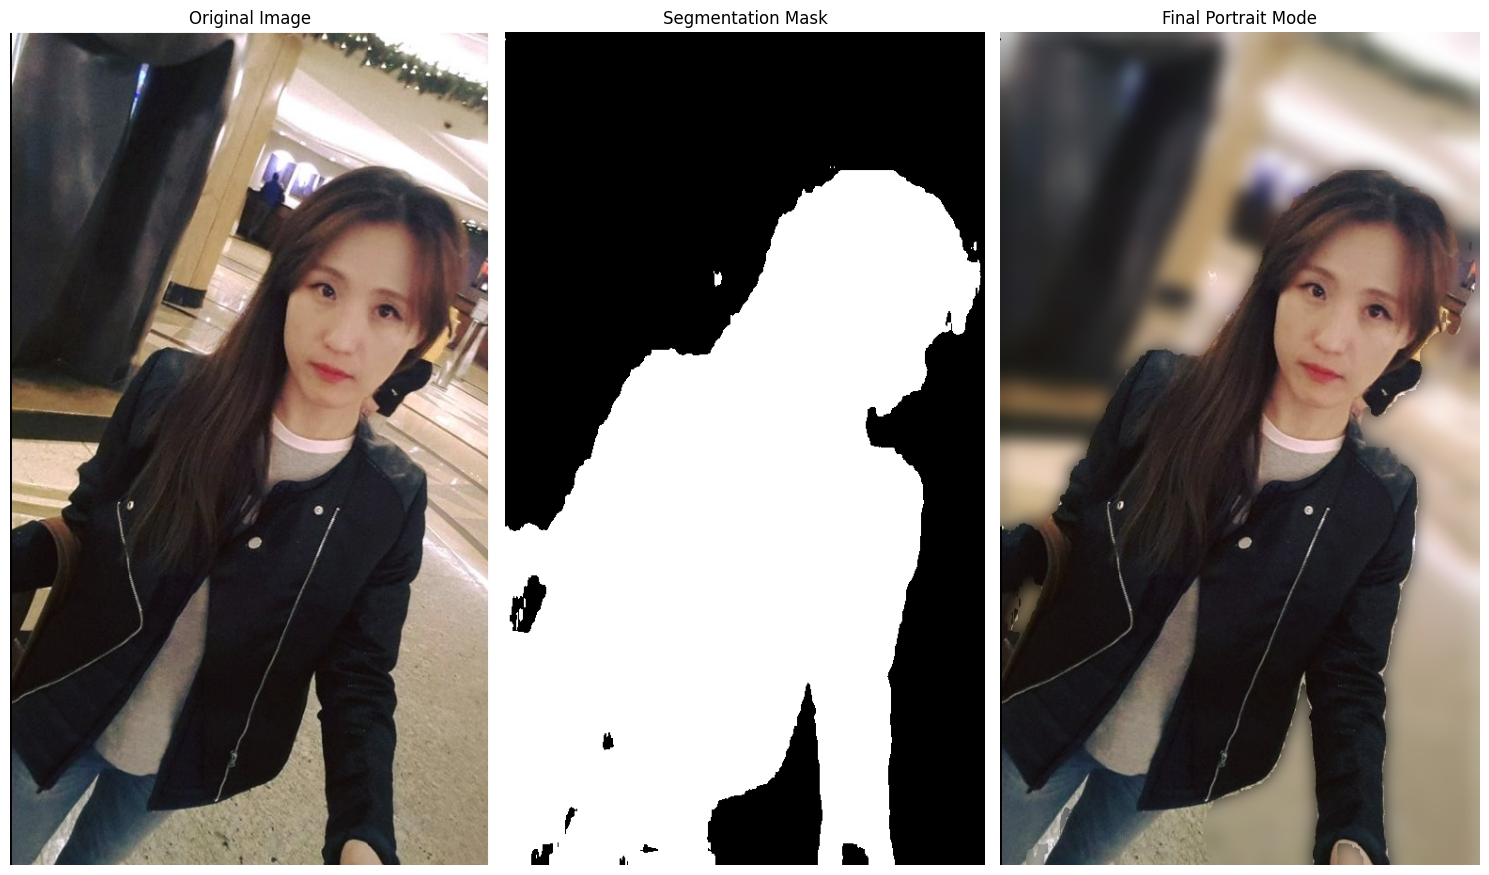

Jihye_KIM.jpg 처리가 완료되었습니다. 결과 저장: /content/drive/MyDrive/AIFFEL_2024/shallow_focus/output_mediapipe/portrait_Jihye_KIM.jpg
모든 이미지 처리가 완료되었습니다.


In [25]:
import mediapipe as mp

# MediaPipe Selfie Segmentation 초기화
mp_selfie_segmentation = mp.solutions.selfie_segmentation
selfie_segmentation = mp_selfie_segmentation.SelfieSegmentation(model_selection=1)

# 이미지 경로 설정
image_folder = '/content/drive/MyDrive/AIFFEL_2024/shallow_focus_data/'
output_folder = '/content/drive/MyDrive/AIFFEL_2024/shallow_focus/output_mediapipe'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 이미지 파일 처리
for image_name in os.listdir(image_folder):
    img_path = os.path.join(image_folder, image_name)

    image = cv2.imread(img_path)
    if image is None:
        print(f"이미지 {image_name}를 읽을 수 없습니다. 건너뜁니다.")
        continue

    # Selfie Segmentation 적용
    results = selfie_segmentation.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # 세그멘테이션 마스크 추출 및 적용
    mask = results.segmentation_mask > 0.5
    mask = np.stack([mask] * 3, axis=-1)  # 3채널 마스크 생성

    # 배경 흐림 처리
    blurred_bg = cv2.GaussianBlur(image, (55, 55), 0)

    # 최종 이미지 생성 (인물은 원본, 배경은 흐림)
    output_image = np.where(mask, image, blurred_bg)

    # 시각적 비교
    fig, axes = plt.subplots(1, 3, figsize=(15, 10))

    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(mask[:, :, 0], cmap='gray')
    axes[1].set_title("Segmentation Mask")
    axes[1].axis('off')

    axes[2].imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    axes[2].set_title("Final Portrait Mode")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    output_path = os.path.join(output_folder, f"portrait_{image_name}")
    cv2.imwrite(output_path, output_image)
    print(f"{image_name} 처리가 완료되었습니다. 결과 저장: {output_path}")

print("모든 이미지 처리가 완료되었습니다.")

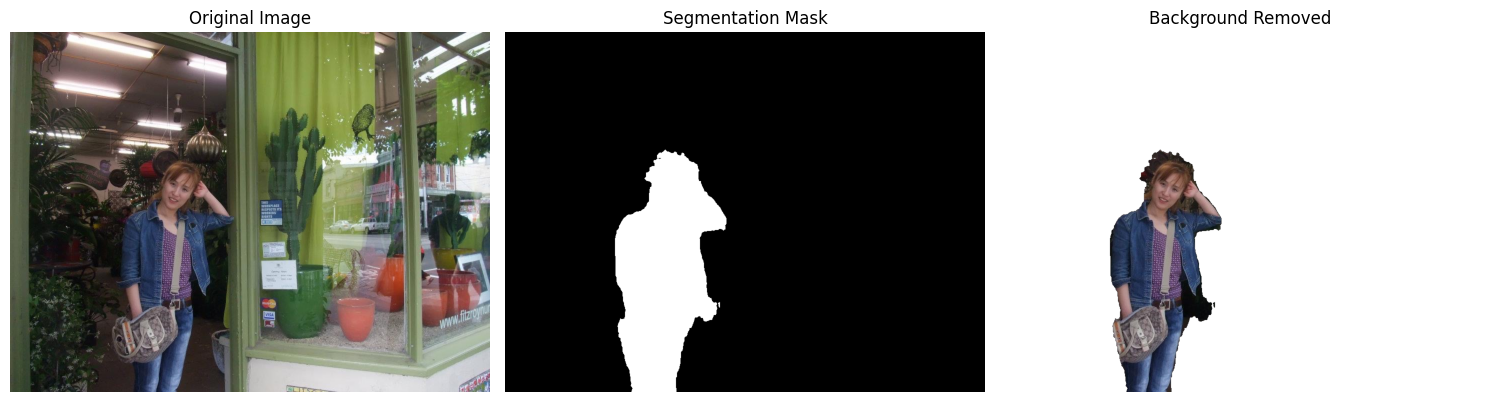

JihyeKIM.JPG 배경 제거 완료. 결과 저장: /content/drive/MyDrive/AIFFEL_2024/shallow_focus/output_only_one/background_removed_JihyeKIM.png


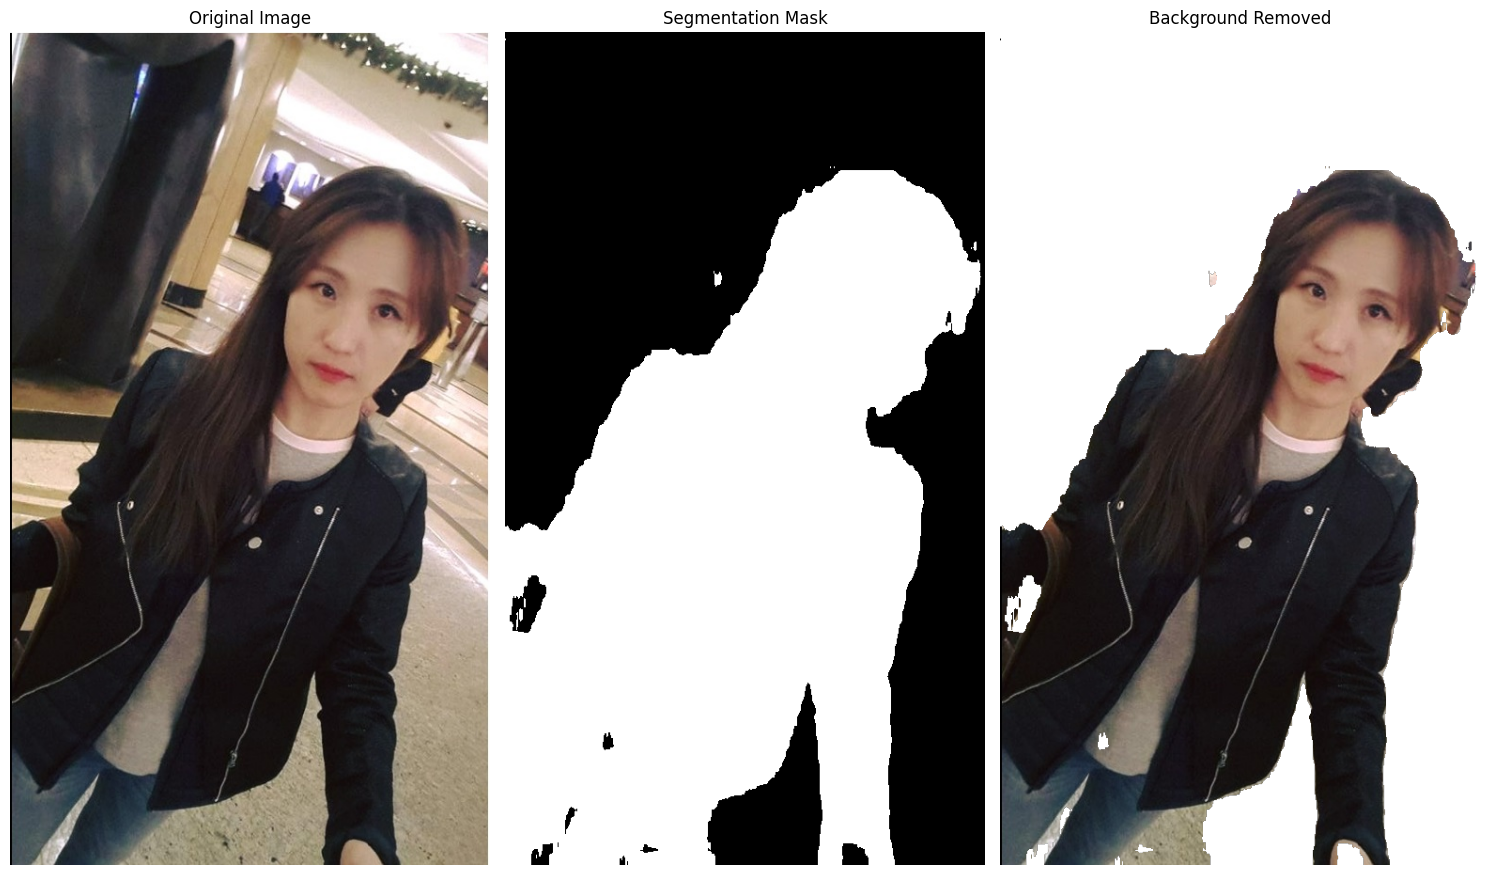

Jihye_KIM.jpg 배경 제거 완료. 결과 저장: /content/drive/MyDrive/AIFFEL_2024/shallow_focus/output_only_one/background_removed_Jihye_KIM.png
모든 이미지 처리가 완료되었습니다.


In [32]:
# MediaPipe Selfie Segmentation 초기화
mp_selfie_segmentation = mp.solutions.selfie_segmentation
selfie_segmentation = mp_selfie_segmentation.SelfieSegmentation(model_selection=1)

# 이미지 경로 설정
image_folder = '/content/drive/MyDrive/AIFFEL_2024/shallow_focus_data/'
output_folder = '/content/drive/MyDrive/AIFFEL_2024/shallow_focus/output_only_one'

# 출력 폴더가 존재하지 않으면 생성
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 이미지 파일 처리
for image_name in os.listdir(image_folder):
    img_path = os.path.join(image_folder, image_name)

    image = cv2.imread(img_path)
    if image is None:
        print(f"이미지 {image_name}를 읽을 수 없습니다. 건너뜁니다.")
        continue

    # Selfie Segmentation 적용
    results = selfie_segmentation.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # 세그멘테이션 마스크 생성
    mask = results.segmentation_mask > 0.5  # True/False로 구성된 마스크
    mask = mask.astype(np.uint8) * 255      # 0 또는 255로 변환 (OpenCV에서 사용하기 위함)

    # 인물만 남기기 (배경을 제거하여 투명하게)
    foreground = cv2.bitwise_and(image, image, mask=mask)

    # 투명 배경을 만들기 위해 4채널 이미지 생성 (RGBA)
    bgra_image = cv2.cvtColor(foreground, cv2.COLOR_BGR2BGRA)

    # 투명도를 위해 알파 채널 추가
    alpha_channel = mask
    bgra_image[:, :, 3] = alpha_channel

    # 시각적 비교
    fig, axes = plt.subplots(1, 3, figsize=(15, 10))

    # 원본 이미지
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # 세그멘테이션 마스크
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title("Segmentation Mask")
    axes[1].axis('off')

    # 배경 제거 결과
    axes[2].imshow(cv2.cvtColor(bgra_image, cv2.COLOR_BGRA2RGBA))
    axes[2].set_title("Background Removed")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    # 결과 저장 (PNG 형식으로 저장해 투명 배경 유지)
    output_path = os.path.join(output_folder, f"background_removed_{image_name.split('.')[0]}.png")
    cv2.imwrite(output_path, bgra_image)
    print(f"{image_name} 배경 제거 완료. 결과 저장: {output_path}")

print("모든 이미지 처리가 완료되었습니다.")